In [1]:
import argparse
import os, sys
import time
import datetime
import numpy as np

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

# You cannot change this lines.
from tools.dataloader import CIFAR10

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x) + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, ResidualBlock):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, 10)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Reference: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
# The original model is a ResNet model. I modified its parameters and changed it to a ResNet-18 model.

In [3]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 50
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 5e-4
EPOCHS = 30
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"

**Your answer:**

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


**Your answer:**

In [5]:
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                          num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=False, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, 
                                        num_workers=1)

Using downloaded and verified file: ./data\cifar10_trainval.tar.gz
Extracting ./data\cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet18(ResidualBlock)
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Successfully loaded checkpoint: ./saved_model/model.h5
Starting from epoch 24 
Starting from learning rate 0.001000:


In [8]:
"""
Assignment 2(c)
In the targeted classification task, we use cross entropy loss with L2 
regularization as the learning object.
You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.
We recommend you to use the SGD-momentum with an initial learning rate 0.01 
and momentum 0.9 as a start.
"""
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(),lr=INITIAL_LR,momentum=MOMENTUM,weight_decay=REG)

In [10]:
# Implement Augmentation and batch normalization
global_step = 0
best_test_acc = 0
train_acc_list = []
test_acc_list = []

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.cuda()
        targets = targets.cuda()
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs,targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += len(targets)
        correct_examples += np.sum((predicted.cpu() - targets.cpu()).numpy() == 0)

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    train_acc_list.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Testing...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    test_loss = 0
    test_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs,targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            if batch_idx == 0:
                final_pred = predicted.cpu().numpy()
            else:
                final_pred = np.append(final_pred,predicted.cpu().numpy())
            # Calculate accuracy
            total_examples += len(targets)
            correct_examples +=  np.sum((predicted.cpu() - targets.cpu()).numpy() == 0)
            test_loss += loss

    avg_loss = test_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    test_acc_list.append(avg_acc)
    print("Testing loss: %.4f, Testing accuracy: %.4f" % (avg_loss, avg_acc))
    
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
    DECAY_EPOCHS = 10
    DECAY = 0.1
    if i % DECAY_EPOCHS == 0 and i != 0:
        if i == 0:
            current_learning_rate = INITIAL_LR
        else:
            current_learning_rate *= DECAY
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f"%current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_test_acc:
        best_test_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

2019-10-01 17:42:04.305836
Epoch 4:
352
Training loss: 0.5239, Training accuracy: 0.8169
2019-10-01 17:43:35.089755
Testing...
Testing loss: 0.6735, Testing accuracy: 0.7658
Saving ...
2019-10-01 17:43:39.437652
Epoch 5:
352
Training loss: 0.4810, Training accuracy: 0.8326
2019-10-01 17:45:13.637821
Testing...
Testing loss: 0.6610, Testing accuracy: 0.7704
Saving ...
2019-10-01 17:45:18.067819
Epoch 6:
352
Training loss: 0.4440, Training accuracy: 0.8461
2019-10-01 17:46:53.181261
Testing...
Testing loss: 0.5628, Testing accuracy: 0.8000
Saving ...
2019-10-01 17:46:57.549379
Epoch 7:
352
Training loss: 0.4157, Training accuracy: 0.8556
2019-10-01 17:48:32.772515
Testing...
Testing loss: 0.6025, Testing accuracy: 0.7980
2019-10-01 17:48:37.067541
Epoch 8:
352
Training loss: 0.3844, Training accuracy: 0.8658
2019-10-01 17:50:12.503019
Testing...
Testing loss: 0.6529, Testing accuracy: 0.7832
2019-10-01 17:50:16.791996
Epoch 9:
352
Training loss: 0.3691, Training accuracy: 0.8722
2019-10-

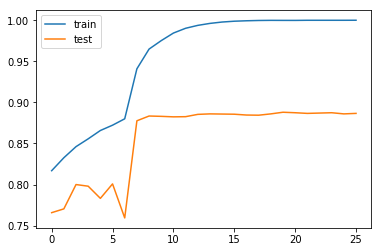

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(EPOCHS-start_epoch),train_acc_list,label='train')
plt.plot(range(EPOCHS-start_epoch),test_acc_list,label='test')
plt.legend()
plt.show()

In [11]:
valset = CIFAR10(root=DATAROOT, train=False, download=False, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, 
                                        num_workers=1)

In [12]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output from the DNN.
        outputs = net(inputs)
        loss = criterion(outputs,targets)
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        if batch_idx == 0:
            final_pred = predicted.cpu().numpy()
        else:
            final_pred = np.append(final_pred,predicted.cpu().numpy())

In [13]:
len(final_pred)

10000

In [14]:
import pandas as pd

pred_df = pd.read_csv('sample_labels.csv')
pred_df['Category'] = final_pred
pred_df.to_csv('test.csv',index=False,sep=',')

In [27]:
from PIL import Image

    
class Testset(torch.utils.data.Dataset):
    def __init__(self,transform=None):
        self.transform = transform
        self.data = np.load('./data/cifar10-batches-images-test.npy')
    
    def __getitem__(self,index):
        img = self.data[index]
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img
    
    def __len__(self):
        return len(self.data)

In [28]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [29]:
testset = Testset(transform = transform_test)

In [30]:
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

In [35]:
testloader.

In [31]:
with torch.no_grad():
    for batch_idx, inputs in enumerate(testloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        if batch_idx == 0:
            final_pred = predicted.cpu().numpy()
        else:
            final_pred = np.append(final_pred,predicted.cpu().numpy())

BrokenPipeError: [Errno 32] Broken pipe

In [24]:
ccx = [2,3,4]

In [26]:
ccx.index(5)

ValueError: 5 is not in list

In [23]:
ccx

[range(2, 5)]